In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
rng = np.random.default_rng(42)

# Simulating neural data with/without a sequence

In [2]:
def poisson_FR(n_neurons: int, FR, duration: float):
    """
    Generates neuronal activity from poisson firing rate for one neurons.
    Input:  - n_neurons:   The number of neurons to simulate.
            - FR:          The firing rate of the poisson process. (array<float>)
            - duration:    The length of recording being simulated in seconds.
    Output: - num_spikes:  The total number of spikes generated.
            - spike_times: Spike timings, sorted.
            - ISI:         Inter-spike intervals between all spikes.
    """
    # Generate number of spikes from poisson distribution
    num_spikes = rng.poisson(FR * duration)
    # Initialize arrays for spike timing and inter-spike interval
    spike_times = np.empty(n_neurons, dtype=object)
    ISI = np.empty(n_neurons, dtype=object)
    for n in range(n_neurons):
        # Draw spike timings from uniform distribution
        spike_times[n] = list(np.sort(rng.uniform(0, duration, num_spikes[n])))
        # Calculate ISI per neuron
        ISI[n] = np.diff(spike_times[n])
    return num_spikes, spike_times, ISI

In [3]:
# Originally Tom's, but changed to exponential distribution instead of Gaussian
def random_FR(n_neurons):
    """
    Draws an array of random firing rates from a gaussian distribution for a specified amount of neurons.
    input:  - n_neurons: The amount of neurons to draw a firing rate for.
    output: - FRs:       Array of firing rates (one FR for each neuron).
    """
    #return rng.normal(mean, sigm, n_neurons)
    return rng.exponential(1/(3.68), n_neurons)

In [4]:
def random_sequence_template(n_neurons, t_start, t_end, nr_in_sequence): # Experiment with time of sequence
    """
    Generate a template from which sequences can be generated. A template is defined as a set of neuron / spike time
    pairs which represent the mean of where and when spikes are expected to happen.
    input:  - nr_neurons:     The total number of neurons in the virtual recording.
            - t_start:        The earliest point in time at which a sequence can begin in seconds.
            - t_end:          The latest point in time at which a sequence can end in seconds.
            - nr_in_sequence: The number of neurons participating in the sequence.
    output: - timings:        The times that neurons are expected to fire
    
    """
    # Sample which neurons participate in the sequence
    participating = rng.choice(n_neurons, nr_in_sequence, replace=False)
    # Initialize array for keeping track of timings.
    timings = np.empty(n_neurons, dtype=object)
    # Set each element to an empty array
    for i in range(n_neurons):
        timings[i] = []
    # For every neuron participating, instead generate a random timing
    for n in participating:
        timings[n].append(rng.uniform(t_start, t_end))
    return timings, participating

In [5]:
def template2sequence(timings, jitter, delay=0):
    """
    Generates a sequence from a sequence template. The resulting sequence resembles the template with some variations
    in spike timing.
    Input:  - timings:       The spike timings in the template.
            - jitter:        Standard deviation of spike timing.
    Output: - spike_timings: The spike timings in the resulting sequence.
    """
    spike_timings = np.empty(timings.shape[0], dtype=object)
    for i in range(timings.shape[0]):
        spike_timings[i] = []
        for t in timings[i]:
            # CHANGED: Assure stimulus-relatedness
            while True:
                t_spike = rng.normal(t, jitter)
                if t_spike > 0: 
                    break
            spike_timings[i].append(t_spike + delay)
    return spike_timings

In [6]:
def embed_sequence(noise, sequence, mode="remove_random"):
    """
    Adds activity and sequence together, removing one spike from the random activity for every spike in the sequence.
    Input:  - noise:         Random poisson firing to embed the sequence in.
            - sequence:      The sequence being embeded
            - mode:          If mode="remove_nearest", nearest spike to sequence spikes will be removed. (currently unimplemented)
                             Add mode: If you add a spike, remove one and increase a similar ISI elsewhere.
                             If you add a spike, you shorten the ISI, so you can go somewhere else with the same ISI and lengthen that ISI.
                             If mode="remove_random", a random spike will be removed from the spike train.
    Output: - spike_timings: Spike timings after embedding
    """
    spike_timings = np.empty(noise.shape[0], dtype=object)
    for i in range(noise.shape[0]):
        if mode == "remove_random":
            spike_timings[i] = list(rng.choice(noise[i], max(len(noise[i]) - len(sequence[i]), 0), replace=False))
        elif mode == "add":
            spike_timings[i] = noise[i]
        else:
            raise Exception("Replacement methods other than \"remove_random\" are not implemented yet.")
        spike_timings[i].extend(sequence[i])
        spike_timings[i].sort()
    return spike_timings

In [7]:
#def simulate_trials(n_trials, n_neurons, duration, has_sequence=False, jitter=0.001, nr_in_sequence=5, seq_window=50, seq_time=1000, p_sequence=1): 
def simulate_unaligned(n_trials, n_neurons, duration, time_btwn_seq=0.2, seq_length=0.05, jitter=0.001, nr_in_sequence=5, p_max = 1, no_seq_buffer = 3, seq_time=1):
    """
    Simulates a number of trials with a commom underlying sequence that repeats within each trial
    as well as between trials, but not at the same time.
    Input:  - n_trials:       Number of trials simulated.
            - n_neurons:      Number of neurons per trial.
            - duration:       Duration of a trial.
            - avg_FR:         Average background firing rate across neurons.
            - FR_var:         Variation of firing rate between neurons.
            - time_btwn_seq:  The average time between sequences.
            - seq_length:     The length of a sequence.
            - jitter:         Jitter / time variability of spikes within the sequence.
            - nr_in_sequence: Number of neurons (spikes) participating in the sequence.
    Output: - trials:         Array containing for each trial, for each neuron the spike times.
    """
    # Generate common sequence
    template, participating = random_sequence_template(n_neurons, 0, seq_length, nr_in_sequence)
    # Determine FR per neuron
    FR = random_FR(n_neurons)
    # Make array to store trials
    trials = np.empty((n_trials, n_neurons), dtype=object)

    if p_max ==0:
        sequence = None
        sorted_seq = None
    
    for i in range(n_trials):
        # Generate background activity
        num_spikes, noise, ISI = poisson_FR(n_neurons, FR, duration)

        if p_max == 0:
            trials[i] = noise
            continue
        
        # Get the sequence markers
        delay = seq_time # CHANGED!!

        # Generate the first sequence (this might break if the delay is randomly too long)
        delay += rng.exponential(scale=time_btwn_seq)
        sequence = template2sequence(template, jitter, delay=delay)
        delay += seq_length

        # Keep generating sequences until there is no space left
        while no_seq_buffer - delay > seq_length:
            # Delay by a random amount
            delay += rng.exponential(scale=time_btwn_seq)
            # DYNAMIC PROBABILITY!!!
            p_sequence = p_max*(-((delay-seq_time)/(no_seq_buffer))**2+1)
            if rng.uniform() <= p_sequence:  # ADDED!
                # Create a sequence and embed it
                seq = template2sequence(template, jitter, delay=delay)
                sequence = embed_sequence(sequence, seq, mode="add")
            # Delay by the length of the sequence
            delay += seq_length
        
        trials[i] = embed_sequence(noise, sequence)

    sorted_seq = np.arange(0, n_neurons)[np.argsort(template)]
    sorted_seq = sorted_seq[n_neurons-len(participating):]

    
    return trials, sequence, sorted_seq

In [8]:
def sim_neuron_locked_sequence(n_neurons, n_trials, duration, time_btwn_seq, seq_length, jitter, nr_in_sequence, p_max, seq_window=2000):
    """
    This code brings together functions by Tom and me to simulate neural data (Tom's function) 
    and subsequently computes their rank and occurrence matrix (my own code)
    """

    # Simulate neural data
    trials, sequences, sorted_seq = simulate_unaligned(n_trials, n_neurons, duration, time_btwn_seq=0.2, seq_length=0.05, jitter=jitter, nr_in_sequence=nr_in_sequence, p_max=p_max)
    
    # Construct spike matrix
    window = [0, duration*1000]
    bin_width = 1
    # Create bins 
    bins = np.arange(window[0],window[1]+1,bin_width)
    spk_matrix = np.zeros([n_trials, n_neurons, len(bins)-1])
    
    for itrial in range(n_trials):
        for ineuron in range(n_neurons):
            spikes = np.array(trials[itrial,ineuron])
            spikes = spikes*1000
            idx = np.where(np.logical_and(spikes>window[0], spikes<window[1]))[0]
            count = np.histogram(spikes[idx],bins)
            spk_matrix[itrial,ineuron,:] = count[0]
    
    # Cut the data to the sequence timing
    seq_window = seq_window+10
    spk_matrix_cut = spk_matrix[:,:,0:0+seq_window] 
    print(sorted_seq)
    return spk_matrix, spk_matrix_cut, sorted_seq

-------------------------------------------------------------------------------------------------------------------------------

# Simulating data

[55 37 46 16 17]
[46 42 23 28 50]
[ 9 24 29 58 20]
[38 37 39 26  9]


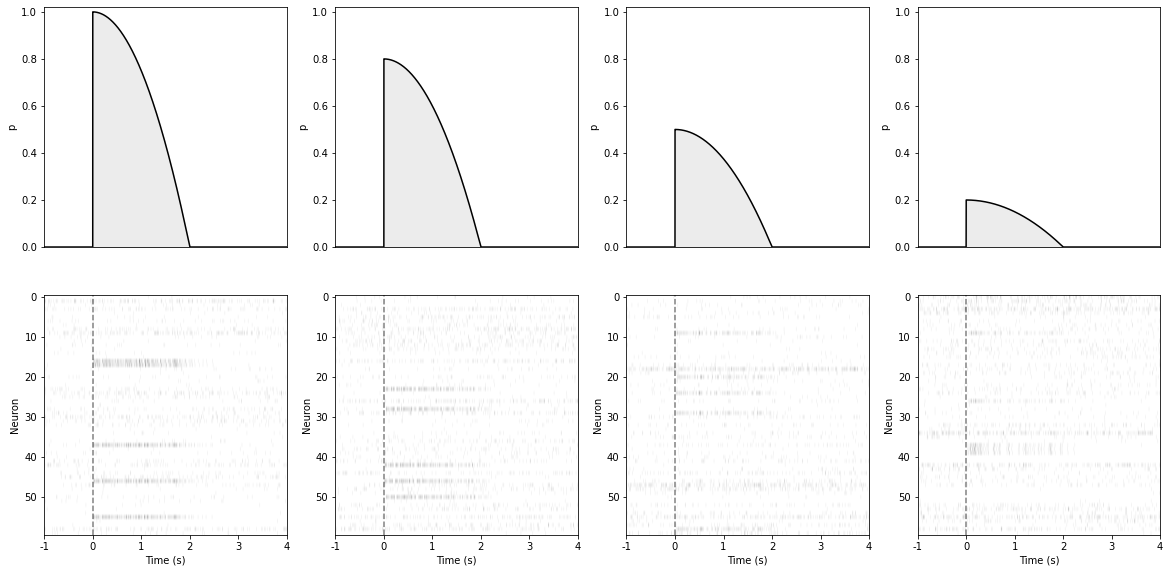

In [12]:
p_max_range = [1, 0.8, 0.5, 0.2]

duration=5
jitter=0.005
n_neurons = 60
n_trials = 30
nr_in_sequence = 5
seq_length=0.05
time_btwn_seq = 0.03

plt.figure(figsize=(20,15))
for ip_max, p_max in enumerate(p_max_range):
    spk_matrix, spk_matrix_cut, sorted_seq = sim_neuron_locked_sequence(n_neurons, n_trials, duration, time_btwn_seq, seq_length, jitter, nr_in_sequence, p_max)
    
    plt.subplot(3, 4, ip_max+1)
    delay=np.arange(5000)
    seq_time=1000
    no_seq_buffer=3000
    dynamic_P = -((delay-seq_time)/(no_seq_buffer-seq_time))**2+1
    dynamic_P = np.array([p if i > seq_time and i < 3000 else 0 for i,p in enumerate(dynamic_P)])
    plt.plot(delay, p_max*dynamic_P, color='black')
    plt.fill_between(delay, p_max*dynamic_P, color='grey', alpha=0.15)
    plt.ylim([0,1.02])
    plt.xlim([0, 5000])  
    plt.xticks([], [])
    plt.ylabel('p')
    
    
    plt.subplot(3, 4, ip_max+5)
    plt.imshow(np.sum(spk_matrix,axis=0),aspect='auto',cmap='gray_r', vmin=0, vmax=1)
    plt.xticks(range(0, 5001, 1000), range(-1, 5, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron')
    ylims = plt.ylim()
    plt.vlines(x = 1000, ymin=ylims[0], ymax= ylims[1],linestyle='--', color='black', alpha=0.5)
    #plt.vlines(x = 3000, ymin=ylims[0], ymax= ylims[1],linestyle='--', color='black', alpha=0.5)
    #plt.fill_between([1000, 3000], y1=60, color='blue', alpha=0.03)
    plt.xlim([0, 5000])   
    
plt.savefig('Figure14.svg')
plt.savefig('Figure14.jpg')
plt.show()        

# Making OCC matrices

In [9]:
# Returns the data where each individual spike is a trial/row, together with the trial labels (which neuron fired)
def spk_triggered(spk_matrix, fr_window):
    spk_triggered_data = [] 
    trial_labels = []
    nbins = 2*fr_window+1
    # For each neuron
    for ineuron in range(spk_matrix.shape[1]):
        rank_matrix = [] # will store all ranks for all spikes in all trials
        for itrial in range(spk_matrix.shape[0]):
            idx = np.where(spk_matrix[itrial,ineuron,:]>0)[0]
            # For every timepoint where the neuron spikes
            for t in idx:
                # Make window surrounding the spike
                spk_window = np.arange(max(t-fr_window, 0),min(t+fr_window+1, spk_matrix.shape[2]))            
                spikes_slice = spk_matrix[itrial]
                spikes_slice = spikes_slice[:,spk_window]

                # If window is of correct size (not at the edges)
                if spikes_slice.shape[1]==nbins:
                    spk_triggered_data.append(spikes_slice)
                    trial_labels.append(ineuron)
    return np.array(spk_triggered_data), trial_labels

[ 2 41 34 55  6]


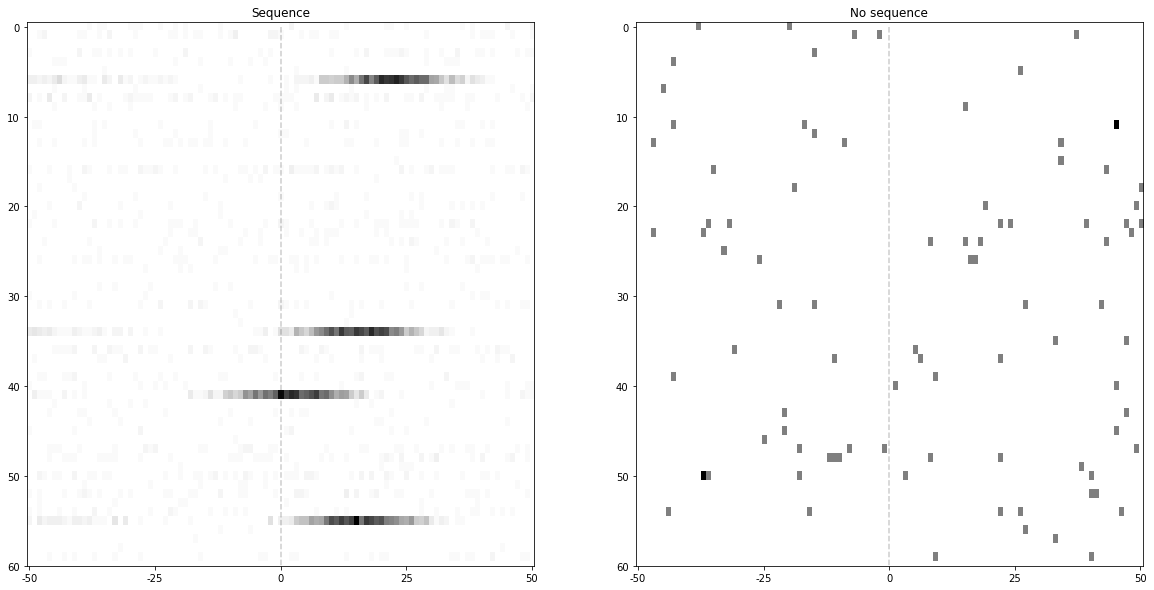

In [12]:
duration=5
n_neurons = 60
n_trials = 100
nr_in_sequence = 5
seq_length=0.05
time_btwn_seq = 0.03
p_max = 1
jitter= 0.005

spk_matrix, spk_matrix_cut, sorted_seq = sim_neuron_locked_sequence(n_neurons, n_trials, duration, time_btwn_seq, seq_length, jitter, nr_in_sequence, p_max=p_max)
triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000))

neuron=sorted_seq[0]

# Mask for particular neuron
triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==neuron)[0]]

# Get rid of locked neuron
triggered_spk_matrix_[:,neuron,:] = np.zeros([triggered_spk_matrix_.shape[0], triggered_spk_matrix_.shape[2]])

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Sequence")
norm = np.sum(triggered_spk_matrix_,axis=0) / np.mean(np.sum(triggered_spk_matrix_,axis=2))
norm[np.isnan(norm)]=0
plt.imshow(norm,aspect='auto', cmap='gray_r')
plt.xticks(range(0, 101, 25), range(-50,51, 25))
plt.vlines(x=50, ymin=0, ymax=n_neurons, color='k', linestyle='--', alpha=0.2)
plt.margins(y=0)

plt.subplot(1, 2, 2)
plt.title("No sequence")
triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,3800:4800], int(seq_length*1000))
neuron=np.argmax(np.sum(np.sum(triggered_spk_matrix, axis=2), axis=0))
# Mask for particular neuron
triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==neuron)[0]]
# Get rid of locked neuron
triggered_spk_matrix_[:,neuron,:] = np.zeros([triggered_spk_matrix_.shape[0], triggered_spk_matrix_.shape[2]])
norm = np.sum(triggered_spk_matrix_,axis=0) / np.mean(np.sum(triggered_spk_matrix_,axis=2))
norm[np.isnan(norm)]=0
plt.imshow(norm,aspect='auto', cmap='gray_r')
plt.xticks(range(0, 101, 25), range(-50,51, 25))
plt.vlines(x=50, ymin=0, ymax=n_neurons, color='k', linestyle='--', alpha=0.2)
plt.margins(y=0)
#plt.savefig('Figure15.jpg')
#plt.savefig('Figure15.svg')
plt.show()  

In [10]:
# My own code
def firing_ranks_spkmatrix(spikes_slice, trigger_neuron):
    """
    Compute the ranks (i.e., the order in which the neurons spiked) of the given data
    """
    
    # Make a vector for average spike times per neuron
    avg_spike = np.zeros([spikes_slice.shape[1]])
    
    # Make a matrix of ranks for each trial
    ranks = np.full([spikes_slice.shape[0], spikes_slice.shape[1]*2+1], np.nan)

    for trial in range(spikes_slice.shape[0]):    
        # Find average spiking time per neuron
        for ineuron in range(spikes_slice.shape[1]):
            avg_spike[ineuron] = np.mean([bin_idx for bin_idx, activity in enumerate(spikes_slice[trial, ineuron]) if activity > 0])
        
        # Sort the neurons, based on their avg spiking time
        sorted_neurons = np.argsort(avg_spike)

        # Find rank of the trigger neuron
        base_rank = np.nonzero(sorted_neurons==trigger_neuron)[0]
        
        
        # Fill the rank matrix, but only for the defined 'rank-slots'
        for ineuron, neuron in enumerate(sorted_neurons):
            if not np.isnan(avg_spike[neuron]):
                ranks[trial,ineuron+spikes_slice.shape[1]-base_rank] = neuron 
    return ranks

In [11]:
def firing_ranks2occ_matrix(firing_ranks):
    """
    Constructs an occurrence matrix from firing ranks where occ[x, y] represents how often neuron x had rank y.
    Input:  - firing_ranks: Array containing for each rank in each trial which neuron had this rank in this trial
    Output: - occ:          Occurrence matrix
    """
    n_neurons = firing_ranks.shape[1]
    occ = np.zeros((n_neurons, n_neurons), dtype=int)
    # Loop over trials
    for trial in firing_ranks:
        # Loop over ranks:
        for rank, neuron in enumerate(trial):
            if np.isnan(neuron):
                continue
            # For not nan rank, neuron pairs, increment the respective square in the occurrence matrix|
            occ[int(neuron), rank] += 1
    return occ

In [12]:
def sort_occ_matrix(occ_matrix, mean_rank=False):   
    """"
    Modifies an occ matrix to only active neurons and 'used' rank positions. 
    Also, it sorts the matrix, either based on mean rank, or on mode rank.
    """
    # Find active neurons
    active_neurons = np.where(np.any(occ_matrix>0, axis=1))[0]

    # Find non-zero rank range
    active_ranks = np.where(np.any(occ_matrix!=0, axis=0))[0]
    if len(active_ranks)<=1:
        rank_limit_1 = 1
        rank_limit_2 = 2
    else:
        rank_limit_1 = active_ranks[1]
        rank_limit_2 = active_ranks[-1]

    # Pick 'active' rows of occ_matrix, for relevant rank range
    occ_matrix = occ_matrix[active_neurons, rank_limit_1:rank_limit_2+1]
    
    # Compute max rank
    max_ranks = np.argmax(occ_matrix, axis=1)
    
    # Compute mean rank
    mean_ranks = np.zeros(len(active_neurons))
    for ineuron, neuron in enumerate(active_neurons):
        mean_ranks[ineuron] = np.mean(occ_matrix[ineuron,:]*np.arange(rank_limit_1, rank_limit_2+1))
    
    
    # Return sorted occ matrix
    if mean_rank:
        return [occ_matrix[np.argsort(mean_ranks),:], np.argsort(mean_ranks), active_neurons]
    else:
        return [occ_matrix[np.argsort(max_ranks),:], np.argsort(max_ranks), active_neurons]

In [15]:
duration=5
n_neurons = 60
n_trials = 100
nr_in_sequence = 5
seq_length=0.05
time_btwn_seq = 0.03
p_max = 0.5
jitter= 0.005
spk_matrix, spk_matrix_cut, sorted_seq = sim_neuron_locked_sequence(n_neurons, n_trials, duration, time_btwn_seq, seq_length, jitter, nr_in_sequence, p_max=p_max)
triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000))

neuron=sorted_seq[2]

# Mask for particular neuron
triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==neuron)[0]]


KeyboardInterrupt



In [14]:
occ = firing_ranks2occ_matrix(firing_ranks_spkmatrix(triggered_spk_matrix_, sorted_seq[2]))

C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


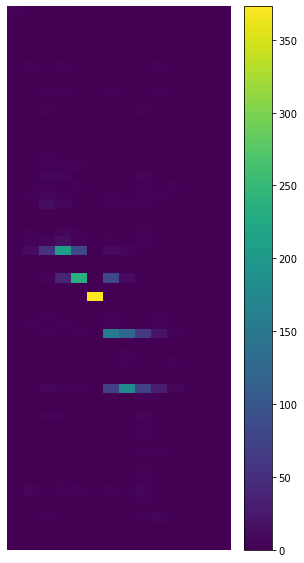

In [32]:
occ_sorted, neurons, order = sort_occ_matrix(occ)
plt.figure(figsize=(5,10))
plt.imshow(occ_sorted, aspect='auto')
plt.xticks(range(occ_sorted.shape[1]), range(occ_sorted.shape[1])-np.unravel_index(np.argmax(occ_sorted), occ_sorted.shape)[1])
plt.colorbar()
plt.axis('off')
plt.savefig('Figure16.svg')
plt.savefig('Figure16.jpg')
plt.show()

# Significance testing

In [13]:
def aligned_firing_ranks2occ_matrix(firing_ranks):
    """
    Constructs an occurrence matrix from firing ranks where occ[x, y] represents how often neuron x had rank y.
    Intended for relative ranks use case.
    Input:  - firing_ranks: Array containing for each rank in each trial which neuron had this rank in this trial
    Output: - occ:          Occurrence matrix
    """
    n_neurons = int((firing_ranks.shape[1]+1)/2)
    occ = np.zeros((n_neurons, n_neurons*2-2), dtype=int)
    # Loop over trials
    for trial in firing_ranks:
        # Loop over ranks:
        for rank, neuron in enumerate(trial):
            if np.isnan(neuron) or rank == n_neurons-1:
                continue
            # For not nan rank, neuron pairs, increment the respective square in the occurrence matrix
            if rank > n_neurons-1:
                occ[int(neuron), rank-1] += 1
            else:
                occ[int(neuron), rank] += 1
    return occ

In [14]:
def MI(M):
    """
    Calculates the mutual information between the 2 axes of a matrix.
    Input:  - M:  2d matrix
    Output: - MI: Mutual information
    """
    sizex = M.shape[0]
    sizey = M.shape[1]
    total = np.sum(M)
    p_Y = np.sum(M, axis=0) / total
    p_X = np.sum(M, axis=1) / total
    # MI = sum over x and y: p(x,y) * log(p(x,y) / (p(x) * p(y)))
    #    = sum over x and y: M(x,y)/total * log((M(x,y) * total) / (p_X(x) * p_Y(y)))
    MI = sum([sum([(
        0 if M[x, y] == 0 else
        M[x, y] / total * np.log((M[x, y] / total) / (p_X[x] * p_Y[y]))
    ) for x in range(sizex)]) for y in range(sizey)])
    return MI

In [15]:
def spikes_in_window(spikes, window_start, window_end):
    return [spike for spike in spikes if spike > window_start and spike < window_end]

cut_spikes = np.vectorize(spikes_in_window, otypes=[object])
vec_mean = np.vectorize(np.mean)
len_vec = np.vectorize(len)

In [30]:
def surrogate_occ_alt(firing_times_per_trial, window=(-50, 50)):
    # Pick random spike
    spk = rng.choice(np.nonzero(firing_times_per_trial.flatten() == 1)[0])  
    trial = np.unravel_index(spk, firing_times_per_trial.shape)[0]
    align_to = np.unravel_index(spk, firing_times_per_trial.shape)[1]
    spike_time = np.unravel_index(spk, firing_times_per_trial.shape)[2]

    relevant_spikes = firing_times_per_trial[trial,:, int(spike_time+window[0]):int(spike_time+window[1])]

    ranks = firing_ranks_spkmatrix(np.reshape(relevant_spikes, [1,relevant_spikes.shape[0], relevant_spikes.shape[1]]), align_to)
    
    return aligned_firing_ranks2occ_matrix(ranks)

In [31]:
def get_URI_nontimelocked(spk_matrix, nr_surrogates, window=(-50, 50)):
    """
    Computes the mutual information between unit and firing rank after aligning windows at spikes of every neuron, per neuron.
    Firing rank is defined as the place in the order of average firing times for a neuron within a trial.
    Input:  - firing_times_per_trial: 2d array containing for each trial, for each neuron the list of firing times
                                      that this neuron produced in this trial.
            - nr_surrogates:          Number of shuffled occurrence matrices to compute p-value. Gets more accurate
                                      with higher numbers.
            - window:                 tuple containing the start and end of the window set around each spike.
    Output: - URI:                    The calculated URI metric.
            - occurrence_matrix:      The occurrence matrix between neuron and rank
            - p-value:                p-value from surrogate calculation. Can be interpreted as the probability of
                                      URI metric being as high as it is under null-hypothesis (no sequence).
    """
    n_neurons = spk_matrix.shape[1]
    URIs = np.zeros(n_neurons)
    nr_windows = np.zeros(n_neurons, dtype=int)

    triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000))

    inactive_neurons = []
    
    for neuron in range(n_neurons):
        triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==neuron)[0]]
        nr_windows[neuron] = len(triggered_spk_matrix_)
        #if len(triggered_spk_matrix_) <= 5: # With less than 5 spikes, the URI will be set to 0.
        #    inactive_neurons.append(neuron)
        #    URI_val = 0
        #else:
        firing_ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, neuron)
        occ_matrix = aligned_firing_ranks2occ_matrix(firing_ranks)
    
            #plt.figure()
            #plt.imshow(sort_occ_matrix(occ_matrix)[0])
            #plt.colorbar()
            #plt.show()
                
        URI_val = MI(occ_matrix)
        URIs[neuron] = URI_val
    
    max_nr_windows = np.max(nr_windows)
    surrogate_stronger = np.zeros(n_neurons, dtype=int)

    for surrogate in range(nr_surrogates):
        surr_occ = [surrogate_occ_alt(spk_matrix, window=window) for _ in range(int(max_nr_windows))]
        
        for neuron in range(n_neurons):
            if len(np.sum(surr_occ[:nr_windows[neuron]], axis=0).shape)<=1:
                surr_URI = 0
            #else:
                #plt.figure()
                #plt.imshow(sort_occ_matrix(np.array(np.sum(surr_occ[:nr_windows[neuron]], axis=0)))[0])
                #plt.colorbar()
                #plt.show()
            else:
                surr_URI = MI(np.sum(surr_occ[:nr_windows[neuron]], axis=0))
                #print(surr_URI)
            if surr_URI >= URIs[neuron]:
                surrogate_stronger[neuron] += 1
    URI_p_vals = surrogate_stronger / nr_surrogates
    return URIs, URI_p_vals

# Significance testing

In [37]:
n_neurons = 80
n_trials = 30
duration = 5
seq_length=0.05
time_btwn_seq = 0.03
jitter = 0.005
nr_in_sequence=5
p_max = 0.8
nr_surrogates = 50

In [44]:
p_window = [1, 0.8, 0.5, 0.3]
jitter_win = [0.005, 0.01, 0.015, 0.02]

n_simulations = 15

recall_matrix = np.zeros([n_simulations, 3])
specificity_matrix = np.zeros([n_simulations, 3])

for noise in range(3):
    nr_in_sequence = 5
    for n in range(n_simulations):
        recall = 0
        specificity = 0
        
        p_max = p_window[noise]
        j = 0.005

        print(p_max)
        print(j)
        spk_matrix, spk_matrix_cut, sorted_seq = sim_neuron_locked_sequence(n_neurons, n_trials, duration, time_btwn_seq, seq_length, j, nr_in_sequence, p_max=p_max)
        URIs, URI_p_vals = get_URI_nontimelocked(spk_matrix, nr_surrogates, window=(-50, 50))
        
        for neur in np.argwhere(URI_p_vals<=0.05): 
            if neur in sorted_seq:
                specificity +=1
             
        for neur in sorted_seq: 
            if neur in np.argwhere(URI_p_vals<=0.05):
                recall +=1

        if np.argwhere(URI_p_vals<=0.05).shape[0] > 0:
            specificity = specificity/np.argwhere(URI_p_vals<=0.05).shape[0]
        else:
            specificity = 1
        recall = recall/len(sorted_seq)

        recall_matrix[n, noise] = recall
        specificity_matrix[n, noise] = specificity

        print(np.argwhere(URI_p_vals<=0.05).shape[0])

        print(recall)
        print(specificity)


1
0.005
[78 25 41  6 20]


C:\Users\pepij\AppData\Local\Temp\ipykernel_28996\891461473.py:10: RuntimeWarning: invalid value encountered in divide
  p_Y = np.sum(M, axis=0) / total
C:\Users\pepij\AppData\Local\Temp\ipykernel_28996\891461473.py:11: RuntimeWarning: invalid value encountered in divide
  p_X = np.sum(M, axis=1) / total


12
0.8
0.3333333333333333
1
0.005
[46 51 13 57 47]
12
1.0
0.4166666666666667
1
0.005
[62  9 21 17 70]
12
0.6
0.25
1
0.005
[29  7 25 64 34]
9
1.0
0.5555555555555556
1
0.005
[24 23 11 33 54]
14
1.0
0.35714285714285715
1
0.005
[54 52 51 46 12]
15
1.0
0.3333333333333333
1
0.005
[45  2 10 26 24]
7
1.0
0.7142857142857143
1
0.005
[48 57 19 35 37]
11
1.0
0.45454545454545453
1
0.005
[50 63 47  2 21]
15
1.0
0.3333333333333333
1
0.005
[29 76 70 36 77]
7
1.0
0.7142857142857143
1
0.005
[ 5 66 20 16 76]
7
1.0
0.7142857142857143
1
0.005
[51 20 17 72 21]
4
0.6
0.75
1
0.005
[31  8 29 77 27]
9
1.0
0.5555555555555556
1
0.005
[66 38 35 68  0]
15
1.0
0.3333333333333333
1
0.005
[37 47 68 20 70]
10
1.0
0.5
0.8
0.005
[41 37 31 59 61]
9
1.0
0.5555555555555556
0.8
0.005
[41 46 25 73 26]
9
0.4
0.2222222222222222
0.8
0.005
[ 6 13 27 76 30]
11
1.0
0.45454545454545453
0.8
0.005
[24 58 16 45 30]
15
0.0
0.0
0.8
0.005
[79 15 46 49 50]
16
0.2
0.0625
0.8
0.005
[24 34 28 10  0]
11
0.8
0.36363636363636365
0.8
0.005
[30  2

IndexError: index 3 is out of bounds for axis 1 with size 3

In [45]:
specificity_matrix

array([[0.33333333, 0.55555556, 0.        ],
       [0.41666667, 0.22222222, 0.        ],
       [0.25      , 0.45454545, 0.625     ],
       [0.55555556, 0.        , 0.13333333],
       [0.35714286, 0.0625    , 0.25      ],
       [0.33333333, 0.36363636, 0.        ],
       [0.71428571, 0.55555556, 0.        ],
       [0.45454545, 0.26666667, 0.33333333],
       [0.33333333, 0.45454545, 0.        ],
       [0.71428571, 0.        , 0.36363636],
       [0.71428571, 0.        , 0.        ],
       [0.75      , 0.        , 0.55555556],
       [0.55555556, 0.4       , 0.2       ],
       [0.33333333, 0.        , 0.38461538],
       [0.5       , 0.        , 0.        ]])

In [46]:
recall_matrix

array([[0.8, 1. , 0. ],
       [1. , 0.4, 0. ],
       [0.6, 1. , 1. ],
       [1. , 0. , 0.4],
       [1. , 0.2, 0.4],
       [1. , 0.8, 0. ],
       [1. , 1. , 0. ],
       [1. , 0.8, 0.6],
       [1. , 1. , 0. ],
       [1. , 0. , 0.8],
       [1. , 0. , 0. ],
       [0.6, 0. , 1. ],
       [1. , 0.4, 0.4],
       [1. , 0. , 1. ],
       [1. , 0. , 0. ]])

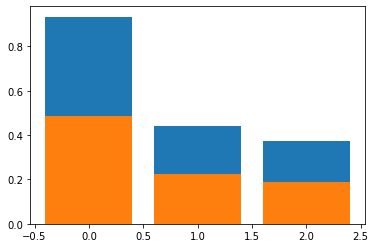

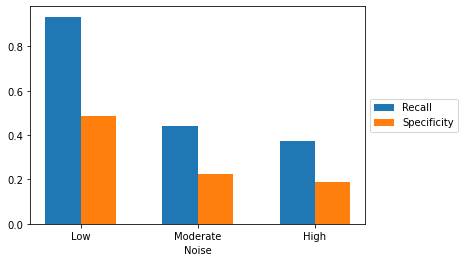

In [54]:
plt.figure()
plt.bar(range(3), np.mean(recall_matrix, axis=0))
plt.bar(range(3), np.mean(specificity_matrix, axis=0))
plt.show()


width=0.3
ind = np.arange(3)

plt.figure()
plt.bar(ind, np.mean(recall_matrix, axis=0) , width, label='Recall')
plt.bar(ind + width, np.mean(specificity_matrix, axis=0), width, label='Specificity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Noise")
plt.xticks(ind + width / 2, ('Low', 'Moderate', 'High'))
plt.savefig('Figuresimneuronlock.svg')
plt.savefig('Figuresimneuronlock.jpg')
plt.show()

[ 6 79 34 51 59]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


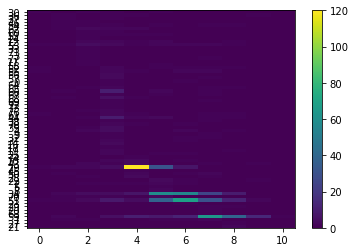

In [18]:
n_neurons = 80


n_trials = 30
duration = 5
seq_length=0.05
time_btwn_seq = 0.03
jitter = 0.005
nr_in_sequence=5
p_max = 0.8
nr_surrogates = 50

spk_matrix, spk_matrix_cut, sorted_seq = sim_neuron_locked_sequence(n_neurons, n_trials, duration, time_btwn_seq, seq_length, jitter, nr_in_sequence, p_max=p_max)

triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000)) 

triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==sorted_seq[0])[0]]

firing_ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, sorted_seq[0])
occ_matrix = aligned_firing_ranks2occ_matrix(firing_ranks)

plt.figure()
plt.imshow(sort_occ_matrix(occ_matrix)[0], aspect='auto')
plt.yticks(range(sort_occ_matrix(occ_matrix)[0].shape[0]), sort_occ_matrix(occ_matrix)[2][sort_occ_matrix(occ_matrix)[1]])
plt.colorbar()
plt.show()

In [19]:
URIs, URI_p_vals = get_URI_nontimelocked(spk_matrix, nr_surrogates, window=(-50, 50))
URI_p_vals

C:\Users\pepij\AppData\Local\Temp\ipykernel_28996\891461473.py:10: RuntimeWarning: invalid value encountered in divide
  p_Y = np.sum(M, axis=0) / total
C:\Users\pepij\AppData\Local\Temp\ipykernel_28996\891461473.py:11: RuntimeWarning: invalid value encountered in divide
  p_X = np.sum(M, axis=1) / total


69
6
44
34
68
2
30
6
48
62
79
51
59
34
62
51
47
14
68
6
68
77
21
69
55
67
6
51
45
11
43
6
51
56
52
33
79
61
24
70
13
59
34
79
53
53
59
16
65
79
32
61
22
59
34
62
54
15
63
20
59
59
2
51
34
2
12
6
29
6
79
68
56
30
44
44
34
77
62
1
24
61
66
9
6
53
61
44
2
12
53
44
8
17
25
62
51
27
65
50
13
34
7
34
6
18
54
36
13
79
44
43
44
48
34
13
62
53
34
61
50
21
76
47
68
51
59
34
79
66
62
32
68
6
36
50
43
54
66
61
57
34
34
2
6
51
61
66
7
35
62
35
34
8
51
31
44
44
79
70
53
53
36
51
68
30
69
59
53
56
6
10
28
34
50
36
15
62
51
8
6
79
2
76
78
59
79
53
6
78
41
53
52
70
48
43
34
13
44
53
44
6
51
4
31
79
66
6
35
34
34
2
70
43
50
52
22
50
52
16
51
13
53
59
6
51
68
62
44
59
60
52
61
50
8
53
38
31
53
59
79
53
51
8
51
79
74
62
60
6
53
76
59
76
4
54
68
56
36
12
21
44
13
48
6
39
28
59
45
12
37
67
5
66
57
53
53
53
44
4
47
16
12
30
19
79
4
46
13
65
35
34
48
60
44
66
52
53
34
55
48
55
72
7
17
70
4
1
62
15
1
53
52
79
53
77
34
46
68
53
62
55
51
59
55
79
12
59
68
68
32
53
62
76
21
10
69
13
3
28
44
43
46
66
61
2
13
63
6


array([0.18, 0.96, 0.36, 0.94, 0.5 , 0.02, 0.  , 1.  , 0.04, 0.58, 0.84,
       0.82, 0.86, 0.3 , 0.34, 0.22, 0.48, 0.82, 0.9 , 0.  , 0.04, 0.14,
       0.4 , 0.42, 0.2 , 0.22, 0.72, 0.06, 0.8 , 0.7 , 0.42, 0.4 , 0.4 ,
       0.34, 0.  , 0.08, 0.08, 0.56, 0.58, 0.72, 0.38, 1.  , 0.84, 0.28,
       0.  , 0.14, 0.08, 0.96, 0.96, 1.  , 0.66, 0.  , 0.44, 0.56, 0.  ,
       0.32, 0.02, 0.12, 0.1 , 0.  , 0.46, 0.16, 0.28, 0.14, 0.02, 0.22,
       0.  , 0.68, 0.08, 0.26, 0.48, 0.  , 0.34, 0.46, 0.18, 1.  , 0.08,
       0.62, 0.94, 0.  ])

In [21]:
np.argwhere(URI_p_vals<= 0.05)

array([[ 5],
       [ 6],
       [ 8],
       [19],
       [20],
       [34],
       [44],
       [51],
       [54],
       [56],
       [59],
       [64],
       [66],
       [71],
       [79]], dtype=int64)

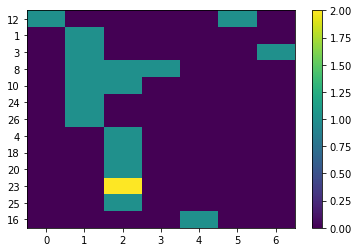

In [101]:
triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==13)[0]]

firing_ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, 13)
occ_matrix = aligned_firing_ranks2occ_matrix(firing_ranks)

plt.figure()
plt.imshow(sort_occ_matrix(occ_matrix)[0], aspect='auto')
plt.yticks(range(sort_occ_matrix(occ_matrix)[0].shape[0]), sort_occ_matrix(occ_matrix)[2][sort_occ_matrix(occ_matrix)[1]])
plt.colorbar()
plt.show()

In [102]:
MI(occ_matrix)

1.1843771005894455

In [78]:
trials = [5, 10, 20, 30, 50]

for tr in trials:
    print(tr)
    URIs, URI_p_vals = get_URI_nontimelocked(spk_matrix[:tr], nr_surrogates, window=(-50, 50))
    print(np.argwhere(URI_p_vals <= 0.05))

5
[[23]]
10
[[ 3]
 [23]
 [27]
 [29]
 [45]]
20


KeyboardInterrupt: 

In [69]:
URI_p_vals

array([0.3 , 1.  , 1.  , 0.84, 1.  , 0.52, 1.  , 1.  , 1.  , 1.  , 0.02,
       1.  , 1.  , 0.08, 0.08, 1.  , 0.  , 1.  , 0.2 , 0.38, 1.  , 0.12,
       1.  , 0.02, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 0.26, 0.02, 0.42, 0.2 , 0.14, 1.  , 0.3 , 0.28,
       1.  , 1.  , 1.  , 1.  , 0.02, 1.  ])

In [70]:
np.argwhere(URI_p_vals <=0.05)

array([[10],
       [16],
       [23],
       [30],
       [37],
       [48]], dtype=int64)

# Results on non-sequential data

In [19]:
duration=5
n_neurons = 50
n_trials = 30
nr_in_sequence = 5
seq_length=0.05
time_btwn_seq = 0.03
p_max = 0.0
jitter= 0.02
nr_surrogates=80
n_simulations = 15
win_range = [5, 25, 50, 75, 100, 125, 150, 175, 200]
p_list = np.zeros([n_simulations, len(win_range), n_neurons])

for n in range(n_simulations):
    print(n)
    spk_matrix, spk_matrix_cut, sorted_seq = sim_neuron_locked_sequence(n_neurons, n_trials, duration, time_btwn_seq, seq_length, jitter, nr_in_sequence, p_max=p_max)

    for iw, w in enumerate(win_range):
        print(w)
        URIs, URI_p_vals =  get_URI_nontimelocked(spk_matrix, nr_surrogates, window=(-w, w))
        p_list[n, iw] = URI_p_vals
        print(URI_p_vals)


0
[32 43 30 22 41]
5


C:\Users\pepij\AppData\Local\Temp\ipykernel_19396\891461473.py:10: RuntimeWarning: invalid value encountered in divide
  p_Y = np.sum(M, axis=0) / total
C:\Users\pepij\AppData\Local\Temp\ipykernel_19396\891461473.py:11: RuntimeWarning: invalid value encountered in divide
  p_X = np.sum(M, axis=1) / total


[0.     1.     0.025  1.     0.     0.     0.     0.0375 0.05   0.0375
 1.     1.     0.0625 0.     0.     0.1    0.     0.15   0.     0.0625
 0.     0.1    0.     0.     0.     1.     0.     0.     0.025  0.
 0.     0.0375 0.425  0.15   0.0375 0.0875 1.     0.1375 1.     0.
 0.0125 1.     0.1    1.     0.025  0.15   0.     0.     0.     0.    ]
25
[0.1    1.     0.25   1.     0.0125 0.025  0.     0.35   0.4875 0.55
 1.     1.     0.55   0.15   0.525  0.4    0.075  0.55   0.025  0.675
 0.1625 0.35   0.     0.0125 0.1375 1.     0.075  0.2125 0.0625 0.1375
 0.025  0.3875 0.6125 0.55   0.3875 0.3625 1.     0.875  1.     0.0625
 0.4125 1.     0.3875 1.     0.3125 0.775  0.05   0.2125 0.1625 0.0125]
50
[0.15   1.     0.5125 1.     0.0375 0.0375 0.0125 0.6375 0.825  0.925
 1.     1.     0.6875 0.3625 0.8625 0.425  0.2125 0.5125 0.0125 0.825
 0.35   0.325  0.0625 0.1    0.1875 1.     0.2875 0.4    0.     0.4125
 0.0125 0.7625 0.25   0.55   0.7625 0.4125 1.     0.9    1.     0.075
 0.7625 1.  

In [36]:
false_positives = np.zeros(len(win_range))
for n in range(15):
    for iw, w in enumerate(win_range):
        false_positives[iw] += (np.count_nonzero(p_list[n, iw]<0.05))

In [45]:
np.mean(p_list[:,0])

0.34265

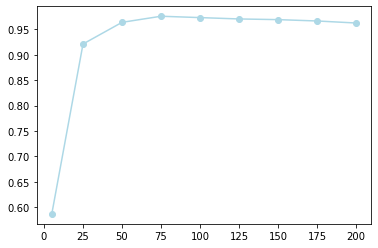

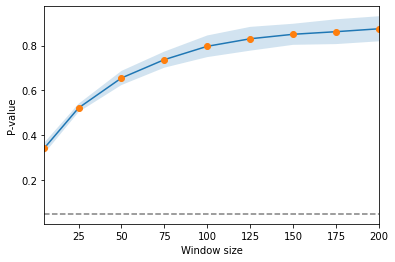

In [50]:
p_list_flat = p_list.flatten()



tn = 15*50-false_positives

width=0.3
ind = np.arange(4)

plt.figure()
plt.plot(win_range, np.array(tn)/(15*50), color='lightblue')
plt.plot(win_range, np.array(tn)/(15*50), 'o',color='lightblue')
plt.savefig('newfig.svg')
plt.show()

res = np.mean(np.mean(p_list, axis=2), axis=0)

plt.figure()
plt.plot(win_range, res)
plt.plot(win_range, res, 'o')
plt.xlabel('Window size')
plt.ylabel('P-value')

plt.fill_between(win_range, res+np.std(np.std(p_list, axis=2), axis=0), res-np.std(np.std(p_list, axis=2), axis=0), alpha=0.2)
plt.hlines(y=0.05, xmin=5, xmax=win_range[-1], linestyle='--', color='k', alpha=0.5)
plt.margins(x=0)
plt.savefig('newfig2.svg')
plt.show()

# Necessary trials 

In [23]:
seq_length=0.05
time_btwn_seq = 0.03
p_max = 0.0
jitter= 0.02


n_neurons = 50
duration = 5
nr_surrogates = 80
n_simulations = 30
n_trials=30

jitter_range = [0.005, 0.01, 0.02]
p_range = [0.8, 0.5, 0.2]

tpr_matrix = np.zeros([3, n_simulations])
specificity_matrix = np.zeros([3, n_simulations])


for noise in range(1,3):
    p = p_range[noise]
    jitter = jitter_range[noise]
    print(p)
    print(jitter)
    for n in range(n_simulations):
        print(n)
        nr_in_sequence = np.random.randint(2, 11)
        spk_matrix, spk_matrix_cut, sorted_seq = sim_neuron_locked_sequence(n_neurons, n_trials, duration, time_btwn_seq, seq_length, jitter, nr_in_sequence, p_max=p)
        
        trial_nr = 30 

        URIs, URI_p_vals =  get_URI_nontimelocked(spk_matrix, nr_surrogates, window=(-50, 50))
        print(URI_p_vals)
        tp = 0
        specificity = 0
        
        for neur in np.argwhere(URI_p_vals<=0.05): 
            if neur in sorted_seq:
                specificity +=1
             

        for neur in sorted_seq: 
            if neur in np.argwhere(URI_p_vals<=0.05):
                tp +=1

        
        tpr = tp/len(sorted_seq)
        if len(np.argwhere(URI_p_vals<=0.05))>0:
            specificity = specificity/len(np.argwhere(URI_p_vals<=0.05))
        else: 
            specificity = 1
            
        print("tpr:"+str(tpr))
        print("specificity:"+str(specificity))
        tpr_matrix[noise, n] = tpr
        specificity_matrix[noise, n] = specificity

0.5
0.01
0
[ 4 22 27  5 45 41 17]


C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pepij\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[0.05   0.     0.325  0.7    1.     1.     0.075  1.     0.0625 0.025
 0.0375 0.275  0.0125 1.     1.     0.225  0.1125 1.     0.3375 1.
 0.05   1.     1.     1.     0.0875 0.225  0.1625 1.     0.3625 0.1625
 0.025  0.0375 0.0375 1.     0.275  0.4375 1.     0.0125 1.     0.0625
 0.     1.     1.     1.     1.     1.     0.1375 0.     0.05   0.2375]
tpr:0.0
specificity:0.0
1
[14  8 41 16]


KeyboardInterrupt: 

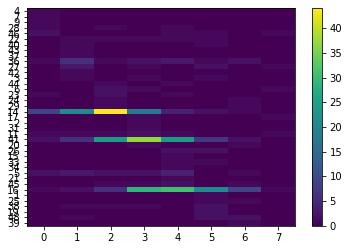

In [42]:
triggered_spk_matrix, trial_labels = spk_triggered(spk_matrix[:,:,1000:3000], int(seq_length*1000))

triggered_spk_matrix_ = triggered_spk_matrix[np.where(np.array(trial_labels)==8)[0]]

firing_ranks = firing_ranks_spkmatrix(triggered_spk_matrix_, 8)
occ_matrix = aligned_firing_ranks2occ_matrix(firing_ranks)

plt.figure()
plt.imshow(sort_occ_matrix(occ_matrix)[0], aspect='auto')
plt.yticks(range(sort_occ_matrix(occ_matrix)[0].shape[0]), sort_occ_matrix(occ_matrix)[2][sort_occ_matrix(occ_matrix)[1]])
plt.colorbar()
plt.show()

URIs, URI_p_vals = get_URI_nontimelocked(spk_matrix, 50, window=(-50, 50))

In [39]:
sorted_seq

array([14,  8, 41, 16])

In [40]:
np.argwhere(URI_p_vals<=0.05)

array([[ 4],
       [22],
       [26],
       [27],
       [38],
       [40],
       [48]], dtype=int64)

In [44]:
URIs

array([0.        , 1.50659509, 1.36346539, 1.47209082, 2.09635258,
       0.59423267, 1.24611122, 1.35126569, 0.45783005, 0.        ,
       1.24068429, 0.98574391, 0.7534802 , 0.        , 0.50924902,
       0.        , 0.4469518 , 1.49522108, 0.        , 1.27697964,
       1.30206139, 1.64884707, 1.1052578 , 1.31043864, 1.34440904,
       1.09741368, 1.21836646, 1.16654656, 0.96728266, 1.35385072,
       0.        , 0.        , 0.        , 1.47171188, 1.12992902,
       0.86756323, 0.66970039, 0.        , 1.19379588, 0.        ,
       1.57649219, 0.53302977, 0.95697882, 1.65655113, 1.32686742,
       0.99671824, 1.03242251, 0.        , 1.28737332, 0.        ])

NameError: name 'tpr_marix' is not defined

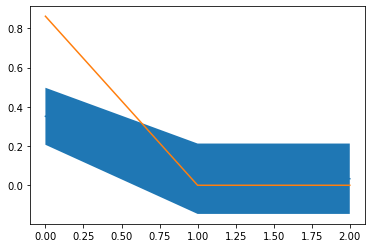

In [22]:
specificity_matrix_mean = np.mean(specificity_matrix, axis=1)
tpr_matrix_mean = np.mean(tpr_matrix, axis=1)

plt.figure()
plt.plot(range(3), specificity_matrix_mean)
plt.fill_between(range(3), specificity_matrix_mean+np.std(specificity_matrix, axis=1), specificity_matrix_mean-np.std(specificity_matrix, axis=1))
plt.plot(range(3), tpr_matrix_mean)
plt.fill_between(range(3), tpr_matrix_mean+np.std(tpr_matrix, axis=1), tpr_matrix_mean-np.std(tpr_marix, axis=1))
plt.legend()
plt.savefig('Simneuronresults.svg')
plt.show()

In [81]:
specificity_result = np.array([[[0.25      , 0.22222222, 0.16666667],
        [0.57142857, 0.5       , 0.57142857],
        [1.        , 1.        , 1.        ],
        [0.88888889, 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.33333333, 0.66666667, 0.4       ],
        [0.66666667, 0.66666667, 0.5       ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 0.5       , 0.4       ],
        [0.8       , 0.8       , 0.5       ],
        [1.        , 1.        , 1.        ],
        [1.        , 0.88888889, 1.        ],
        [1.        , 1.        , 1.        ]]])